<a href="https://colab.research.google.com/github/yarathealmighty/sokoban-rl/blob/main/sokoban_rl_save.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
notes:
stable-baselines3
  easy to use
  - try
samplefactory
  gyors, nagyon gyors
  - may try (iffy)
rllib
  ipari
  - EHHHHHHHH
torchrl
  nem keretlib, bonyolultabb használat -> neurális háló
  - might be a skip
"""

# Sokoban-RL

In [1]:
!git clone https://github.com/szegedai/sokoban_gym_szte.git

Cloning into 'sokoban_gym_szte'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 119 (delta 53), reused 91 (delta 34), pack-reused 0
Receiving objects: 100% (119/119), 34.75 KiB | 741.00 KiB/s, done.
Resolving deltas: 100% (53/53), done.


In [2]:
!mv sokoban_gym_szte/* .

In [3]:
!pip install gymnasium
!pip install --no-deps stable-baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 3.2 MB/s eta 0:00:00


In [4]:
from stable_baselines3 import A2C
from stable_baselines3.common.sb2_compat.rmsprop_tf_like import RMSpropTFLike
from sokoban_gym.envs.sokoban_env import SokobanEnv
import gymnasium as gym
from utils.eval_utils import evaluate, create_videos

# 2d struktúra kihasználása

In [5]:
from sokoban_gym.wrappers.observation import ImageObservationWrapper

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# Környezet létrehozása
env = gym.make('Sokoban-v1', size=[(5,5),(6,6),(7,7)], padded_size=(7, 7), num_boxes=[1], render_mode='rgb_array')

In [7]:
# A megfigyelések kiterjesztése a tábla alapján számolt új jellemzők segítségével.
env = ImageObservationWrapper(env, scale=8)

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.padded_size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.padded_size` for environment variables or `env.get_wrapper_attr('padded_size')` that will search the reminding wrappers.
  logger.warn(


In [8]:
def get_map(env):
  return env.unwrapped.grid

def set_map(env, seed_num):
  env.reset(seed=seed_num)

def get_hw(map):
  height = len(map)
  width = len(map[0])
  return (height, width)

def get_goals(map):
  goal_coords = []
  for i in range(0,len(map)):
    for j in range(0,len(map[0])):
      if map[i][j] == 3:
        goal_coords.append((i,j))
  return goal_coords

def get_boxes(map):
  box_coords = []
  for i in range(0,len(map)):
    for j in range(0,len(map[0])):
      if map[i][j] == 2:
        box_coords.append((i,j))
  return box_coords

  def get_player(map):
    for i in range(0,len(map)):
      for j in range(0,len(map[0])):
        if map[i][j] == 4:
          return (i,j)

In [9]:
def how_many_boxes_are_in_goal(box_coords, goal_coords):
  counter=0
  for box in box_coords:
    box_inplace = False
    for goal in goal_coords:
      if box == goal:
        counter+=1
        break
  return (counter)

In [10]:
def box_checker(box_coords,goal_coords,map):
    box_coords_new = box_coords.copy()
    goal_coords_new = goal_coords.copy()
    if len(box_coords) == 0 or len(goal_coords) == 0:
      return (len(box_coords) - len(box_coords_new),box_coords_new,goal_coords_new)
    for box in box_coords_new:
      for goal in goal_coords_new:
        if box == goal:
          box_coords_new.remove(box)
          goal_coords_new.remove(goal)
          break
    if is_any_box_in_corner(box_coords_new,map):
      return (-1,box_coords_new,goal_coords_new)

    return (len(box_coords) - len(box_coords_new),box_coords_new,goal_coords_new)


In [11]:
def is_any_box_in_corner(box_coords, map):
  for box in box_coords:
    x = box[0]
    y = box[1]
    if x == 0:
      if y == 0:
        return True
      else:
        if y == len(map[0]) -1:
          return True
        else:
          # top row
          if map[x][y-1] == 1 or map[x][y+1] == 1:
            return True
    else:
      if x == len(map) -1:
        if y == 0:
          return True
        else:
          if y == len(map[0]) -1:
            return True
          else:
            # bottom row
            if map[x][y-1] == 1 or map[x][y+1] == 1:
              return True
      else:
        # anywhere inside
        if map[x][y-1] == 1 and map[x-1][y] == 1:
              return True
        if map[x][y+1] == 1 and map[x-1][y] == 1:
              return True
        if map[x][y-1] == 1 and map[x+1][y] == 1:
              return True
        if map[x][y+1] == 1 and map[x+1][y] == 1:
              return True
  return False

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
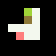

In [ ]:
env.reset(seed=63)[0]

In [12]:
def same_maps(map1, map2):
    if len(map1) != len(map2) or len(map1[0]) != len(map2[0]):
        return False
    for i in range(len(map1)):
        for j in range(len(map1[i])):
            if map1[i][j] != map2[i][j]:
                return False
    return True

In [13]:
import numpy as np
def copy_map(map1):
  map2 = []
  for row in map1:
    row2 = []
    for element in row:
      row2.append(element)
    map2.append(row2)
  converted_map = np.array(map2)
  return converted_map

In [14]:
class CustomRewardWrapper(gym.Wrapper):

  def __init__(self, env):
    super().__init__(env)
    self.map = None
    self.previous_map = None
    self.init_run = True

  def step(self, action):
    obs, reward, terminated, truncated, info = self.env.step(action)
    # saving the previous map
    if not self.init_run:
      self.previous_map = copy_map(self.map)

    # getting the current map
    self.map = copy_map(get_map(env))
    box_coords = get_boxes(self.map)

    # initializing run
    if self.init_run:
      self.same_steps = 0
      self.goal_coords = info['target_locations']
      self.init_run = False
      boxes_num = how_many_boxes_are_in_goal(box_coords,self.goal_coords)
      tmp_num = boxes_num - len(box_coords)
      reward +=  tmp_num
      return obs, reward, terminated, truncated, info

    # checking if the agent did anything that changed the map
    if same_maps(self.map, self.previous_map):
      reward -= 10 * self.same_steps
      self.same_steps += 1
    else:
      self.same_steps = 0
# ----------------------------<testing part>----------------------------



# -------------------------<end of testing part>------------------------

    # checking how many boxes are currently in place
    tmp = box_checker(box_coords,self.goal_coords,self.map)
    if tmp == -1:
      reward -= 10000

    reward += tmp[0]

    # checking if game got reset
    if terminated:
      reward += 100
      self.init_run = True

    return obs, reward, terminated, truncated, info

In [15]:
# Környezet létrehozása
env = gym.make('Sokoban-v1', size=[(5,5),(6,6),(7,7)], padded_size=(7, 7), num_boxes=[1], render_mode='rgb_array')
# A megfigyelések kiterjesztése a tábla alapján számolt új jellemzők segítségével.
env = ImageObservationWrapper(env, scale=8)
# Modell létrehozása
env = CustomRewardWrapper(env)
model = A2C('CnnPolicy', env, policy_kwargs=dict(optimizer_class=RMSpropTFLike, optimizer_kwargs=dict(eps=1e-7)), verbose=4, seed=1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [16]:
env.reset(seed=42)
print('----------------------------------------')
obs, reward, terminated, truncated, info = env.step(4)
print('[LOG]reward: ',reward)
print('[LOG]map: \n',env.map)
print('[LOG]terminated: ', terminated, ' truncated: ', truncated)
print('[LOG]box_checker: ',box_checker(get_boxes(env.map),env.goal_coords,env.map))
print('[LOG]boxes: ', get_boxes(env.map), ' goals: ', env.goal_coords)
print('----------------------------------------')
obs, reward, terminated, truncated, info = env.step(1)
print('[LOG]reward: ',reward)
print('[LOG]map: \n',env.map)
print('[LOG]terminated: ', terminated, ' truncated: ', truncated)
print('[LOG]box_checker: ',box_checker(get_boxes(env.map),env.goal_coords,env.map))
print('[LOG]boxes: ', get_boxes(env.map), ' goals: ', env.goal_coords)
print('----------------------------------------')
obs, reward, terminated, truncated, info = env.step(4)
print('[LOG]reward: ',reward)
print('[LOG]map: \n',env.map)
print('[LOG]terminated: ', terminated, ' truncated: ', truncated)
print('[LOG]box_checker: ',box_checker(get_boxes(env.map),env.goal_coords,env.map))
print('[LOG]boxes: ', get_boxes(env.map), ' goals: ', env.goal_coords)
print('----------------------------------------')
obs, reward, terminated, truncated, info = env.step(2)
print('[LOG]reward: ',reward)
print('[LOG]map: \n',env.map)
print('[LOG]terminated: ', terminated, ' truncated: ', truncated)
print('[LOG]box_checker: ',box_checker(get_boxes(env.map),env.goal_coords,env.map))
print('[LOG]boxes: ', get_boxes(env.map), ' goals: ', env.goal_coords)

----------------------------------------
[LOG]reward:  -1.0
[LOG]map: 
 [[1 1 1 1 1 1 1]
 [1 0 0 0 1 1 1]
 [1 0 4 2 1 1 1]
 [1 1 0 3 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]]
[LOG]terminated:  False  truncated:  False
[LOG]box_checker:  (0, [(2, 3)], [(3, 3)])
[LOG]boxes:  [(2, 3)]  goals:  [(3, 3)]
----------------------------------------
[LOG]reward:  0.0
[LOG]map: 
 [[1 1 1 1 1 1 1]
 [1 0 4 0 1 1 1]
 [1 0 0 2 1 1 1]
 [1 1 0 3 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]]
[LOG]terminated:  False  truncated:  False
[LOG]box_checker:  (0, [(2, 3)], [(3, 3)])
[LOG]boxes:  [(2, 3)]  goals:  [(3, 3)]
----------------------------------------
[LOG]reward:  0.0
[LOG]map: 
 [[1 1 1 1 1 1 1]
 [1 0 0 4 1 1 1]
 [1 0 0 2 1 1 1]
 [1 1 0 3 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]]
[LOG]terminated:  False  truncated:  False
[LOG]box_checker:  (0, [(2, 3)], [(3, 3)])
[LOG]boxes:  [(2, 3)]  goals:  [(3, 3)]
----------------------------------------
[LOG]re

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
# Tanulás
model.learn(total_timesteps=4000)
# Model kimentése
model.save("models/Sokoban-v1_5_8_1box_A2C_CNN")
# Kiértékelés 100 véletlen környezetben
score = evaluate(env, model, 100)
print("Score: {}".format(score))

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 30.7     |
|    ep_rew_mean        | -121     |
| time/                 |          |
|    fps                | 108      |
|    iterations         | 100      |
|    time_elapsed       | 4        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.61    |
|    explained_variance | 0.00191  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -39.8    |
|    value_loss         | 771      |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 31.7     |
|    ep_rew_mean        | -194     |
| time/                 |          |
|    fps                | 145      |
|    iterations         | 200      |
|    time_elapsed       | 6        |
|    total_timesteps    | 1000     |
| train/                |          |
|

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:284: UserWarning: Path 'models' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")
100%|██████████| 100/100 [00:08<00:00, 11.64it/s]

Score: -10490.02


In [40]:
# Videók készítése
create_videos(env, model, folder="cnn_videos", ep_num=10)
show_videos("cnn_videos")

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/cnn_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
  0%|          | 0/10 [00:00<?, ?it/s]

Moviepy - Building video /content/cnn_videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/cnn_videos/rl-video-episode-0.mp4




 10%|█         | 1/10 [00:00<00:01,  5.90it/s]

Moviepy - Done !
Moviepy - video ready /content/cnn_videos/rl-video-episode-0.mp4
Moviepy - Building video /content/cnn_videos/rl-video-episode-1.mp4.
Moviepy - Writing video /content/cnn_videos/rl-video-episode-1.mp4




 20%|██        | 2/10 [00:00<00:01,  5.84it/s]

Moviepy - Done !
Moviepy - video ready /content/cnn_videos/rl-video-episode-1.mp4


 20%|██        | 2/10 [00:00<00:01,  5.84it/s]

Moviepy - Building video /content/cnn_videos/rl-video-episode-2.mp4.
Moviepy - Writing video /content/cnn_videos/rl-video-episode-2.mp4




 30%|███       | 3/10 [00:00<00:01,  5.57it/s]

Moviepy - Done !
Moviepy - video ready /content/cnn_videos/rl-video-episode-2.mp4


 30%|███       | 3/10 [00:00<00:01,  5.57it/s]

Moviepy - Building video /content/cnn_videos/rl-video-episode-3.mp4.


 30%|███       | 3/10 [00:00<00:01,  5.57it/s]

Moviepy - Writing video /content/cnn_videos/rl-video-episode-3.mp4




 40%|████      | 4/10 [00:00<00:01,  5.32it/s]

Moviepy - Done !
Moviepy - video ready /content/cnn_videos/rl-video-episode-3.mp4
Moviepy - Building video /content/cnn_videos/rl-video-episode-4.mp4.
Moviepy - Writing video /content/cnn_videos/rl-video-episode-4.mp4




 50%|█████     | 5/10 [00:00<00:00,  5.43it/s]

Moviepy - Done !
Moviepy - video ready /content/cnn_videos/rl-video-episode-4.mp4


 50%|█████     | 5/10 [00:01<00:00,  5.43it/s]

Moviepy - Building video /content/cnn_videos/rl-video-episode-5.mp4.
Moviepy - Writing video /content/cnn_videos/rl-video-episode-5.mp4




 60%|██████    | 6/10 [00:01<00:00,  5.51it/s]

Moviepy - Done !
Moviepy - video ready /content/cnn_videos/rl-video-episode-5.mp4


 60%|██████    | 6/10 [00:01<00:00,  5.51it/s]

Moviepy - Building video /content/cnn_videos/rl-video-episode-6.mp4.
Moviepy - Writing video /content/cnn_videos/rl-video-episode-6.mp4




 70%|███████   | 7/10 [00:01<00:00,  5.63it/s]

Moviepy - Done !
Moviepy - video ready /content/cnn_videos/rl-video-episode-6.mp4


 70%|███████   | 7/10 [00:01<00:00,  5.63it/s]

Moviepy - Building video /content/cnn_videos/rl-video-episode-7.mp4.
Moviepy - Writing video /content/cnn_videos/rl-video-episode-7.mp4




 80%|████████  | 8/10 [00:01<00:00,  5.51it/s]

Moviepy - Done !
Moviepy - video ready /content/cnn_videos/rl-video-episode-7.mp4


 80%|████████  | 8/10 [00:01<00:00,  5.51it/s]

Moviepy - Building video /content/cnn_videos/rl-video-episode-8.mp4.
Moviepy - Writing video /content/cnn_videos/rl-video-episode-8.mp4




 90%|█████████ | 9/10 [00:01<00:00,  5.50it/s]

Moviepy - Done !
Moviepy - video ready /content/cnn_videos/rl-video-episode-8.mp4


 90%|█████████ | 9/10 [00:01<00:00,  5.50it/s]

Moviepy - Building video /content/cnn_videos/rl-video-episode-9.mp4.
Moviepy - Writing video /content/cnn_videos/rl-video-episode-9.mp4




100%|██████████| 10/10 [00:01<00:00,  5.93it/s]

Moviepy - Done !
Moviepy - video ready /content/cnn_videos/rl-video-episode-9.mp4

SHOWING VIDEO cnn_videos/rl-video-episode-0.mp4



SHOWING VIDEO cnn_videos/rl-video-episode-1.mp4



SHOWING VIDEO cnn_videos/rl-video-episode-2.mp4



SHOWING VIDEO cnn_videos/rl-video-episode-3.mp4



SHOWING VIDEO cnn_videos/rl-video-episode-4.mp4



SHOWING VIDEO cnn_videos/rl-video-episode-5.mp4



SHOWING VIDEO cnn_videos/rl-video-episode-6.mp4



SHOWING VIDEO cnn_videos/rl-video-episode-7.mp4



SHOWING VIDEO cnn_videos/rl-video-episode-8.mp4



SHOWING VIDEO cnn_videos/rl-video-episode-9.mp4


In [20]:
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_videos(folder="video"):
  # A glob modul glob.glob() függvényével keresünk minden .mp4 kiterjesztésű fájlt a megadott mappában.
  # Az eredmény egy lista lesz az összes talált .mp4 fájl elérési útjával.
  mp4list = glob.glob(folder + '/*.mp4')

  # A talált videófájlok listáját rendezzük, hogy biztosítsuk a megjelenítés sorrendjét.
  mp4list.sort()


  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")

    # Megnyitjuk a videófájlt olvasásra (bináris módban), és beolvassuk a tartalmát.
    video = io.open(mp4, 'r+b').read()

    # A videófájl tartalmát Base64 kódolással kódoljuk, hogy beágyazható legyen egy HTML dokumentumba.
    encoded = base64.b64encode(video)

    # Videók megjelenítése a colab HTML írási lehetőségeit felhasználva.
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))


In [42]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.sb2_compat.rmsprop_tf_like import RMSpropTFLike
from sokoban_gym.envs.sokoban_env import SokobanEnv
import gymnasium as gym
from utils.eval_utils import evaluate, create_videos

# Környezet létrehozása
env = gym.make('Sokoban-v1', size=[(5,5),(6,6),(7,7)], padded_size=(7, 7), num_boxes=[1], render_mode='rgb_array')
# A megfigyelések kiterjesztése a tábla alapján számolt új jellemzők segítségével.
env = ImageObservationWrapper(env, scale=8)
# Modell létrehozása
# env = CustomRewardWrapper(env)
# Wrap the environment in a DummyVecEnv to make it compatible with Stable Baselines 3
model = PPO('MlpPolicy', env, policy_kwargs=dict(optimizer_class=RMSpropTFLike, optimizer_kwargs=dict(eps=1e-7)), verbose=4, seed=42)
# Tanulás
model.learn(total_timesteps=25000)
# Model kimentése
model.save("models/Sokoban-v1_5_8_1box_PPO_CNN")
# Kiértékelés 100 véletlen környezetben
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)
print("Mean reward:", mean_reward, "±", std_reward)
# Videók készítése
create_videos(env, model, folder="ppo_videos", ep_num=10)
show_videos("ppo_videos")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.4     |
|    ep_rew_mean     | 0.441    |
| time/              |          |
|    fps             | 405      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 33            |
|    ep_rew_mean          | 0.48          |
| time/                   |               |
|    fps                  | 369           |
|    iterations           | 2             |
|    time_elapsed         | 11            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 4.1498977e-05 |
|    clip_fraction        | 0           

  0%|          | 0/10 [00:00<?, ?it/s]

Moviepy - Building video /content/ppo_videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/ppo_videos/rl-video-episode-0.mp4




 10%|█         | 1/10 [00:00<00:01,  6.80it/s]

Moviepy - Done !
Moviepy - video ready /content/ppo_videos/rl-video-episode-0.mp4


 10%|█         | 1/10 [00:00<00:01,  6.80it/s]

Moviepy - Building video /content/ppo_videos/rl-video-episode-1.mp4.
Moviepy - Writing video /content/ppo_videos/rl-video-episode-1.mp4




 20%|██        | 2/10 [00:00<00:01,  6.15it/s]

Moviepy - Done !
Moviepy - video ready /content/ppo_videos/rl-video-episode-1.mp4


 20%|██        | 2/10 [00:00<00:01,  6.15it/s]

Moviepy - Building video /content/ppo_videos/rl-video-episode-2.mp4.
Moviepy - Writing video /content/ppo_videos/rl-video-episode-2.mp4




 30%|███       | 3/10 [00:00<00:01,  6.29it/s]

Moviepy - Done !
Moviepy - video ready /content/ppo_videos/rl-video-episode-2.mp4


 30%|███       | 3/10 [00:00<00:01,  6.29it/s]

Moviepy - Building video /content/ppo_videos/rl-video-episode-3.mp4.
Moviepy - Writing video /content/ppo_videos/rl-video-episode-3.mp4




 40%|████      | 4/10 [00:00<00:01,  5.85it/s]

Moviepy - Done !
Moviepy - video ready /content/ppo_videos/rl-video-episode-3.mp4


 40%|████      | 4/10 [00:00<00:01,  5.85it/s]

Moviepy - Building video /content/ppo_videos/rl-video-episode-4.mp4.
Moviepy - Writing video /content/ppo_videos/rl-video-episode-4.mp4




 50%|█████     | 5/10 [00:00<00:00,  5.82it/s]

Moviepy - Done !
Moviepy - video ready /content/ppo_videos/rl-video-episode-4.mp4


 50%|█████     | 5/10 [00:00<00:00,  5.82it/s]

Moviepy - Building video /content/ppo_videos/rl-video-episode-5.mp4.
Moviepy - Writing video /content/ppo_videos/rl-video-episode-5.mp4




 50%|█████     | 5/10 [00:00<00:00,  5.82it/s]

Moviepy - Done !
Moviepy - video ready /content/ppo_videos/rl-video-episode-5.mp4


 50%|█████     | 5/10 [00:01<00:00,  5.82it/s]

Moviepy - Building video /content/ppo_videos/rl-video-episode-6.mp4.
Moviepy - Writing video /content/ppo_videos/rl-video-episode-6.mp4




 70%|███████   | 7/10 [00:01<00:00,  6.96it/s]

Moviepy - Done !
Moviepy - video ready /content/ppo_videos/rl-video-episode-6.mp4


 70%|███████   | 7/10 [00:01<00:00,  6.96it/s]

Moviepy - Building video /content/ppo_videos/rl-video-episode-7.mp4.
Moviepy - Writing video /content/ppo_videos/rl-video-episode-7.mp4




 70%|███████   | 7/10 [00:01<00:00,  6.96it/s]

Moviepy - Done !
Moviepy - video ready /content/ppo_videos/rl-video-episode-7.mp4


 70%|███████   | 7/10 [00:01<00:00,  6.96it/s]

Moviepy - Building video /content/ppo_videos/rl-video-episode-8.mp4.
Moviepy - Writing video /content/ppo_videos/rl-video-episode-8.mp4




 90%|█████████ | 9/10 [00:01<00:00,  7.63it/s]

Moviepy - Done !
Moviepy - video ready /content/ppo_videos/rl-video-episode-8.mp4


 90%|█████████ | 9/10 [00:01<00:00,  7.63it/s]

Moviepy - Building video /content/ppo_videos/rl-video-episode-9.mp4.
Moviepy - Writing video /content/ppo_videos/rl-video-episode-9.mp4




100%|██████████| 10/10 [00:01<00:00,  6.84it/s]

Moviepy - Done !
Moviepy - video ready /content/ppo_videos/rl-video-episode-9.mp4

SHOWING VIDEO ppo_videos/agent_video-step-0-to-step-1000.mp4



SHOWING VIDEO ppo_videos/rl-video-episode-0.mp4



SHOWING VIDEO ppo_videos/rl-video-episode-1.mp4



SHOWING VIDEO ppo_videos/rl-video-episode-2.mp4



SHOWING VIDEO ppo_videos/rl-video-episode-3.mp4



SHOWING VIDEO ppo_videos/rl-video-episode-4.mp4



SHOWING VIDEO ppo_videos/rl-video-episode-5.mp4



SHOWING VIDEO ppo_videos/rl-video-episode-6.mp4



SHOWING VIDEO ppo_videos/rl-video-episode-7.mp4



SHOWING VIDEO ppo_videos/rl-video-episode-8.mp4



SHOWING VIDEO ppo_videos/rl-video-episode-9.mp4
